In [566]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import plot_roc_curve

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import NMF, PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix, precision_score, 
                                    recall_score, accuracy_score, r2_score, 
                                    plot_confusion_matrix)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, plot_confusion_matrix
from sklearn.cluster import DBSCAN

from sklearn import (
    cluster, decomposition, ensemble, manifold, 
    random_projection, preprocessing)
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# from sklearn.neighbors import KNeighborsRegressor

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import random

import json

In [567]:
df = pd.read_json('../../data/basic_dataset.json')

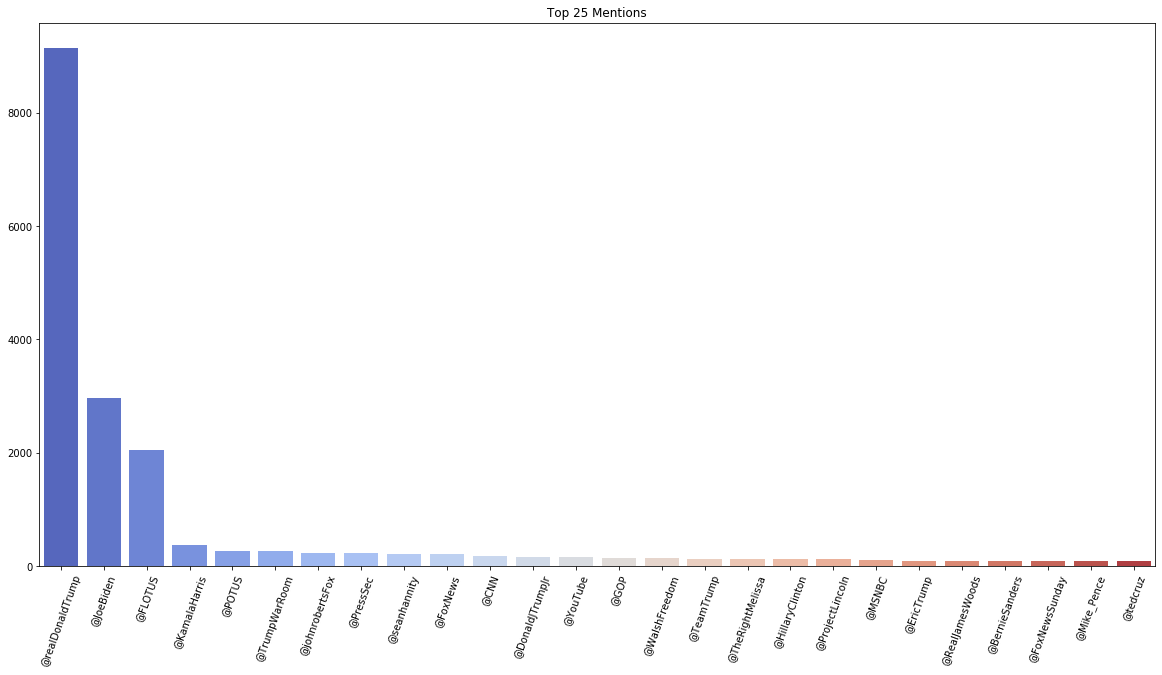

In [568]:
screen_names = {}
for text in df.tweet_text:
    if text[:3] == 'RT ':
        pass
    elif '@' in text:
        lst = text.split()
        ats = [at for at in lst if at[0] == '@']
        for names in ats:
            names = names.replace(':', '')
            if names not in screen_names:
                screen_names[names] = 1
            else:
                screen_names[names] += 1
    else:
        pass
    
names = np.array(list(screen_names.keys()))
count = np.array(list(screen_names.values()))
top_25_names = names[count.argsort()[::-1]][:26]
top_25_count = count[count.argsort()[::-1]][:26]
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(top_25_names, top_25_count, palette='coolwarm')
plt.xticks(rotation=70)
plt.title('Top 25 Mentions');

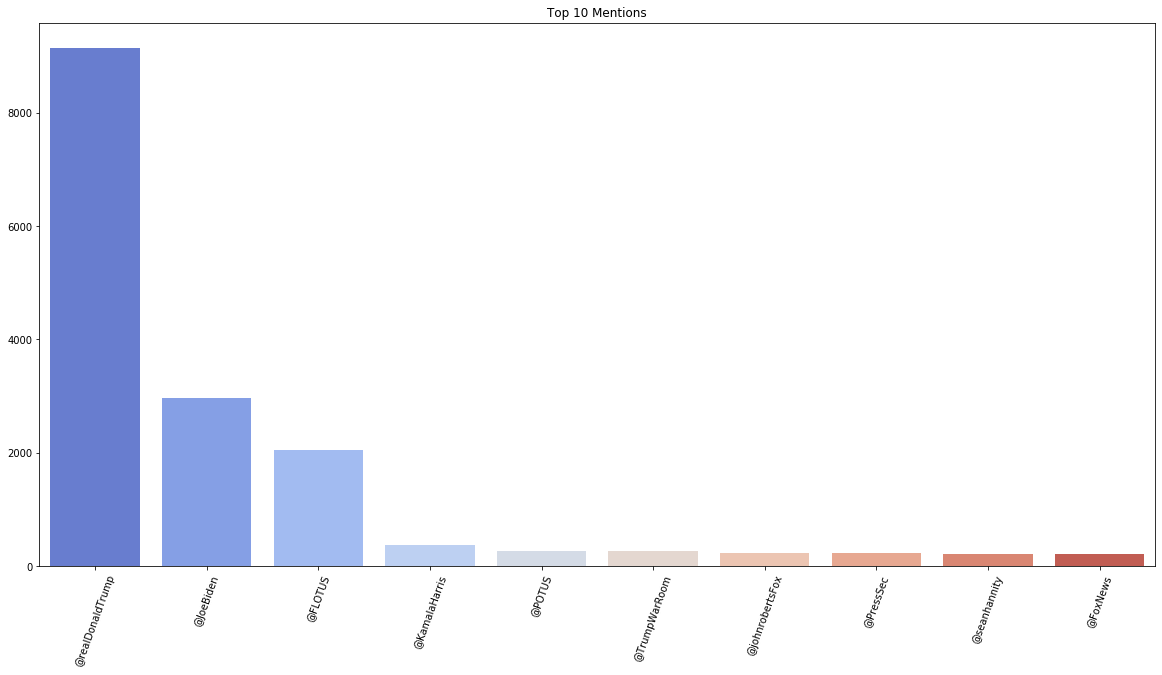

In [569]:
top_10_names = names[count.argsort()[::-1]][:10]
top_10_count = count[count.argsort()[::-1]][:10]
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(top_10_names, top_10_count, palette='coolwarm')
plt.xticks(rotation=70)
plt.title('Top 10 Mentions')
plt.savefig('../images/top_ten_mentions.png');

In [570]:
non_rt_df = df[df['is_retweet'] == 0]
mentions = []
for i in top_10_names:
    for text in non_rt_df.tweet_text:
        mentions.append((i in text)*1)
        
slices = np.linspace(len(non_rt_df.tweet_text), len(mentions), 10)

for i in range(len(top_10_names)):
    if i == 0:
        non_rt_df[f'mentions_{top_10_names[i]}'] = mentions[:int(slices[i])]
    else:
        non_rt_df[f'mentions_{top_10_names[i]}'] = mentions[int(slices[i-1]):int(slices[i])]


/home/heather/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/heather/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [596]:
encoded_df.head()

,tweet_text,mentions_@realDonaldTrump,mentions_@JoeBiden,mentions_@FLOTUS,mentions_@KamalaHarris,mentions_@POTUS,mentions_@TrumpWarRoom,mentions_@johnrobertsFox,mentions_@PressSec,mentions_@seanhannity,mentions_@FoxNews,retweets
0,biden a professional debater?? hardly!! more l...,0,0,0,0,0,0,0,0,0,0,0
2,how can biden stand a chance against trump in ...,0,0,0,0,0,0,0,0,0,0,25
11,@laggerific @jondoc900 @joebiden you may get b...,0,1,0,0,0,0,0,0,0,0,0
17,@rodala2904 @eleazar_arocha la causa de trump ...,0,0,0,0,0,0,0,0,0,0,0
24,@gopchairwoman who doe donald trump owe money ...,0,0,0,0,0,0,0,0,0,0,0


WORK WITH JUST THE FEATURES WE WANT TO PREDICT RETWEETS

In [571]:
encoded_df = non_rt_df[['tweet_text','mentions_@realDonaldTrump',
       'mentions_@JoeBiden', 'mentions_@FLOTUS', 'mentions_@KamalaHarris',
       'mentions_@POTUS', 'mentions_@TrumpWarRoom', 'mentions_@johnrobertsFox',
       'mentions_@PressSec', 'mentions_@seanhannity', 'mentions_@FoxNews', 'retweets']]

In [572]:
def lemmatizer(string):
    # Lemmatize a string and return it in its original format
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(w)
                    for w in w_tokenizer.tokenize(string)
                    if "http" not in w])

encoded_df['tweet_text'] = encoded_df['tweet_text'].apply(lambda x: str(x).lower())
encoded_df['tweet_text'] = encoded_df['tweet_text'].apply(lambda x: lemmatizer(x))

/home/heather/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/heather/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Vectorize the bitch

In [579]:
stop_words = list(STOPWORDS)
stop_words.append('rt')

In [602]:
def orig_vect(X_train, custom_stopwords):
    '''
    pass in x training data to fit and transform to

    Returns:
     vectorizer, x_train vectorized
    '''
    vectorizer = TfidfVectorizer(stop_words=custom_stopwords, max_features = 1000, analyzer='word', ngram_range=(1,2))
    x_train_vect = vectorizer.fit_transform(X_train)
    return vectorizer, x_train_vect

In [603]:
vectorizer, x_train_vect = orig_vect(encoded_df.tweet_text, stop_words)

/home/heather/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [604]:
#combine vecotized tweets with other onehot encoded columns into one matrix
vect_tweets = x_train_vect.todense()
other_cols = np.array(encoded_df.iloc[:, 1:-1])
X = np.concatenate((vect_tweets, other_cols), axis = 1)

In [606]:
y = encoded_df['retweets'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.25)

scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_jobs=-1, max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.8152060127315961, -1.7541573427482922)

In [540]:
features = vectorizer.get_feature_names()
vect_features = x_train_vect.toarray().mean(axis = 0)

In [541]:
top_words = np.array(features)[vect_features.argsort()[::-1][:100]]

Text(0.5, 1.0, 'Top Terms')

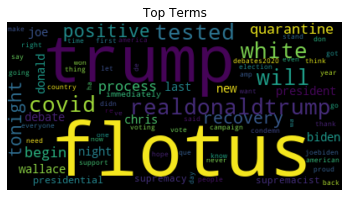

In [542]:
fig, ax = plt.subplots()

wordcloud = WordCloud().generate(' '.join(top_words))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title('Top Terms')
# plt.savefig('Debate_wordcloud.png');

In [310]:
for i in df.columns:
    print(i)

tweet_id
tweet_date
tweet_text
is_reply
is_quote
is_retweet
sensitive
hashtags
mentions
u_verified
u_egg
u_followers
u_created
retweets
favorites
lower_text
lemmatized


In [314]:
y = df['retweets'].values
X_train, X_test, y_train, y_test = train_test_split(x_train_vect.todense(), y, random_state = 1, test_size = 0.25)
scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_jobs=-1, max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_train, y_train), model.score(X_test, y_test)

Find top screen names and Hashtags that are mentioned and one hot and code those

HEATHER

That will tell us if using the hashtags gets more engagement on Twitter

 'entities.user_mentions', 'entities.hashtags'

In [17]:
for i in df.columns:
    print(i)

created_at
id
id_str
full_text
truncated
display_text_range
source
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
geo
coordinates
place
contributors
is_quote_status
quoted_status_id
quoted_status_id_str
retweet_count
favorite_count
favorited
retweeted
possibly_sensitive
lang
entities.hashtags
entities.symbols
entities.user_mentions
entities.urls
user.id
user.id_str
user.name
user.screen_name
user.location
user.description
user.url
user.entities.description.urls
user.protected
user.followers_count
user.friends_count
user.listed_count
user.created_at
user.favourites_count
user.utc_offset
user.time_zone
user.geo_enabled
user.verified
user.statuses_count
user.lang
user.contributors_enabled
user.is_translator
user.is_translation_enabled
user.profile_background_color
user.profile_background_image_url
user.profile_background_image_url_https
user.profile_background_tile
user.profile_image_url
user.profile_image_url_https
user

In [246]:
# screen_names = {}
# for i in range(len(lst)):
#     sn = lst[i]['screen_name']
#     if sn not in screen_names:
#         screen_names[sn] = 1
#     else:
#         screen_names[sn] += 1
# print(screen_names)

In [388]:
# import ast
# # >>> ast.literal_eval("{'muffin' : 'lolz', 'foo' : 'kitty'}")
# # {'muffin': 'lolz', 'foo': 'kitty'}
# # ast.literal_eval(df['entities.user_mentions'].values[1:][0][1:-1])

# s = df['entities.user_mentions'].values[1:][0][1:-1]
# json_acceptable_string = s.replace("'", "\"")

# d = json.loads(json_acceptable_string)

One hot and Code the top 10 mentions 

In [445]:
top_10_names

array(['@realDonaldTrump', '@JoeBiden', '@FLOTUS', '@KamalaHarris',
       '@POTUS', '@TrumpWarRoom', '@johnrobertsFox', '@PressSec',
       '@seanhannity', '@FoxNews'], dtype='<U127')

In [482]:
non_rt_df = df[df['is_retweet'] == 0]

In [483]:
len(top_10_names)

10

In [484]:
non_rt_df.tweet_text[0]

'Biden a professional debater??  Hardly!! More like a professional liar! https://t.co/cQuxzexXYt'

One Hot and Code

In [500]:
# mentions = []
# for ind, text in enumerate(non_rt_df.tweet_text):
#     new_mentions = any(name in text for name in top_10_names)*1
#     mentions.append(new_mentions)
len(mentions)

334370

In [486]:
mentions = []
for i in top_10_names:
    for text in non_rt_df.tweet_text:
        mentions.append((i in text)*1)
        

In [487]:
len(non_rt_df.tweet_text)

33437

In [497]:
mentions = []
for i in top_10_names:
    for text in non_rt_df.tweet_text:
        mentions.append((i in text)*1)
        
slices = np.linspace(len(non_rt_df.tweet_text), len(mentions), 10)
len(mentions[0:int(slices[0])]), \
len(mentions[int(slices[0]):int(slices[1])]), \
len(mentions[int(slices[1]):int(slices[2])]),\
len(mentions[int(slices[8]):int(slices[9])])

(33437, 33437, 33437, 33437)

In [498]:
top_10_names[9]

'@FoxNews'

In [501]:
for i in range(len(top_10_names)):
    print(i)
    if i == 0:
        non_rt_df[f'mentions_{top_10_names[i]}'] = mentions[:int(slices[i])]
    else:
        non_rt_df[f'mentions_{top_10_names[i]}'] = mentions[int(slices[i-1]):int(slices[i])]


0
1
2
3
4
5
6
7
8
9


/home/heather/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/heather/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [529]:
non_rt_df.retweets

0          0
2         25
11         0
17         0
24         0
          ..
140319     0
140324     0
140326    16
140333     0
140334     0
Name: retweets, Length: 33437, dtype: int64

In [513]:
new_df = non_rt_df[['tweet_text','mentions_@realDonaldTrump',
       'mentions_@JoeBiden', 'mentions_@FLOTUS', 'mentions_@KamalaHarris',
       'mentions_@POTUS', 'mentions_@TrumpWarRoom', 'mentions_@johnrobertsFox',
       'mentions_@PressSec', 'mentions_@seanhannity', 'mentions_@FoxNews']]

In [ ]:

scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [531]:
X = np.array(new_df.iloc[:, 1:])
y = non_rt_df.retweets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.25)


model = RandomForestRegressor(n_jobs=-1, max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_train, y_train), model.score(X_test, y_test)

(9.993206901393048e-05, -0.0058517806727373944)

In [ ]:
y = df['retweets'].values
X_train, X_test, y_train, y_test = train_test_split(x_train_vect.todense(), y, random_state = 1, test_size = 0.25)
scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_jobs=-1, max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_train, y_train), model.score(X_test, y_test)